# Exploratory Data Analysis

In [30]:
import pandas as pd
import os
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
# activate matplotlib and set style
% matplotlib inline
plt.style.use('ggplot')

In [2]:
# path to short element json file
short_elements_dir = os.path.join(os.pardir,'data', 'interim', 'short_elements.json')

In [3]:
# decode json file
with open(short_elements_dir, encoding='utf-8') as f:
    d = json.load(f)

In [70]:
# retrieve institution information
df_institution = json_normalize(d, record_path='Institution', meta=['award_id', 'amount', 'eff_date'])

In [71]:
df_institution.head()

,City,Country,Name,State,StreetAddress,amount,award_id,eff_date
0,BERKELEY,United States,University of California-Berkeley,CA,Sponsored Projects Office,125000,6000001,04/15/1960
1,Washington,United States,The Geochemical Society,DC,Carnegie Institution for Science,28000,6100002,12/15/1961
2,BLACKSBURG,United States,Virginia Polytechnic Institute and State Unive...,VA,Sponsored Programs 0170,40160,6100003,12/15/1961
3,WASHINGTON,United States,American Association For Advancement Science,DC,"1200 NEW YORK AVENUE, N.W.",,6100004,02/15/1962
4,ARLINGTON,United States,American Anthropological Assoc,VA,"2300 Clarendon Blvd, Suite 1301",1334824,6100005,02/15/1962


### Deal with missing data

In [72]:
df_institution.amount.replace('', pd.np.nan, inplace = True)

In [73]:
df_institution.amount = df_institution.amount.astype('float64')

In [74]:
df_institution.Name.replace('', pd.np.nan, inplace = True)

In [77]:
df_institution.eff_date = pd.to_datetime(df_institution.eff_date, format='%m/%d/%Y')
df_institution.set_index('eff_date', inplace = True)

In [78]:
df_institution.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 438574 entries, 1960-04-15 to 2017-11-01
Data columns (total 7 columns):
City             438574 non-null object
Country          438574 non-null object
Name             438573 non-null object
State            438574 non-null object
StreetAddress    438574 non-null object
amount           438467 non-null float64
award_id         438574 non-null int32
dtypes: float64(1), int32(1), object(5)
memory usage: 25.1+ MB


### Take a look at institutions

In [79]:
df_count = df_institution[df_institution.amount.notnull()].groupby('Name').amount.agg(['sum', 'count'])

In [80]:
df_count.rename(columns={'sum' : 'total_amount', 'count': 'num_grant'}, inplace=True)

In [81]:
df_count.head()

,total_amount,num_grant
Name,,
DATA NOT AVAILABLE,215000.0,1
18F GSA,1509064.0,4
21ST CENTURY EXPO GROUP,0.0,1
21st Century School Fund,426044.0,2
27 International Geographical Congress,883860.0,2


In [82]:
# normalize to billions of dollars
df_count.total_amount = df_count.total_amount/1e9

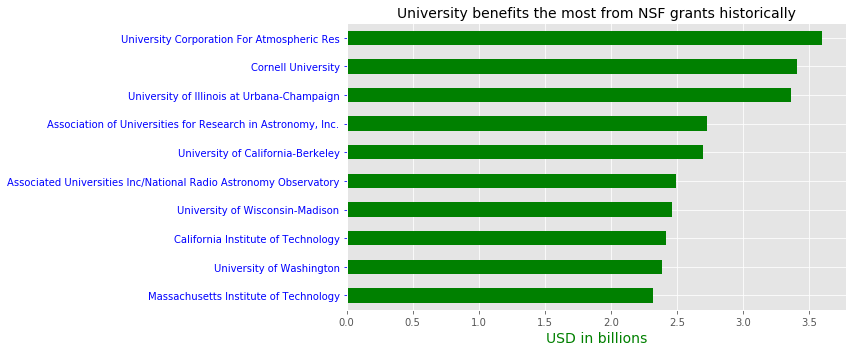

In [83]:
fig , ax = plt.subplots(figsize = (12, 5))
df_count.sort_values('total_amount', ascending=False).head(10).total_amount.plot.barh(ax=ax, color='g')
ax.invert_yaxis()
ax.set_xlabel('USD in billions', color='g', fontsize = 14)
ax.tick_params(axis = 'y', colors = 'b')
ax.set_ylabel('')
_= ax.set_title('University benefits the most from NSF grants historically', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(os.pardir, 'img', 'TotalAmount.png'))

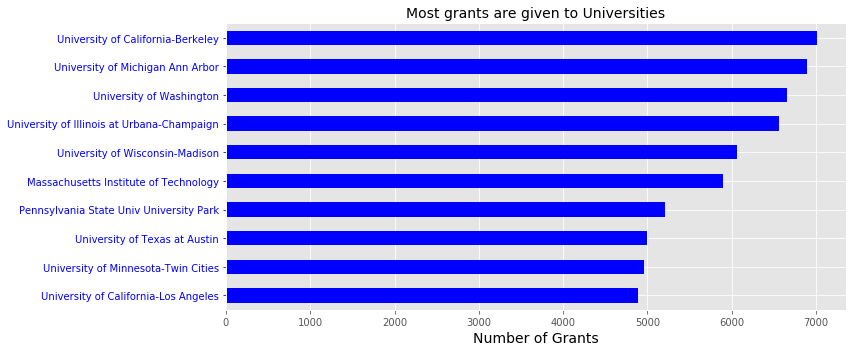

In [84]:
fig2 , ax2 = plt.subplots(figsize = (12, 5))
df_count.sort_values('num_grant', ascending=False).head(10).num_grant.plot.barh(ax=ax2, color='b')
ax2.invert_yaxis()
ax2.set_xlabel('Number of Grants', color='k', fontsize = 14)
ax2.tick_params(axis = 'y', colors = 'b')
ax2.set_ylabel('')
_= ax2.set_title('Most grants are given to Universities', fontsize=14)
plt.tight_layout()
fig2.savefig(os.path.join(os.pardir, 'img', 'Number0fgrants.png'))

In [85]:
df_institution.loc['amount']

,City,Country,Name,State,StreetAddress,amount,award_id
eff_date,,,,,,,
1960-04-15,BERKELEY,United States,University of California-Berkeley,CA,Sponsored Projects Office,125000.0,6000001
1961-12-15,Washington,United States,The Geochemical Society,DC,Carnegie Institution for Science,28000.0,6100002
1961-12-15,BLACKSBURG,United States,Virginia Polytechnic Institute and State Unive...,VA,Sponsored Programs 0170,40160.0,6100003
1962-02-15,WASHINGTON,United States,American Association For Advancement Science,DC,"1200 NEW YORK AVENUE, N.W.",NaN,6100004
1962-02-15,ARLINGTON,United States,American Anthropological Assoc,VA,"2300 Clarendon Blvd, Suite 1301",1334824.0,6100005


In [58]:
df_sorted = df_institution.sort_values(['award_id', 'Name']).copy()

In [59]:
df_sorted.set_index('award_id')

,City,Country,Name,State,StreetAddress,amount
award_id,,,,,,
0,BLACKSBURG,United States,Virginia Polytechnic Institute and State Unive...,VA,Sponsored Programs 0170,0.0
9,GAINESVILLE,United States,University of Florida,FL,1 UNIVERSITY OF FLORIDA,280000.0
26,RALEIGH,United States,North Carolina State University,NC,CAMPUS BOX 7514,292026.0
27,Austin,United States,University of Texas at Austin,TX,"3925 West Braker Lane, Ste 11072",238000.0
31,Austin,United States,University of Texas at Austin,TX,"3925 West Braker Lane, Ste 11072",285000.0
33,Reno,United States,"Board of Regents, NSHE, obo University of Neva...",NV,1664 North Virginia Street,84000.0
39,Savannah,United States,Skidaway Institute of Oceanography,GA,10 Ocean Science Circle,526579.0
42,KEY BISCAYNE,United States,University of Miami Rosenstiel School of Marin...,FL,4600 RICKENBACKER CSWY,377123.0
47,TALLAHASSEE,United States,Florida State University,FL,"874 Traditions Way, 3rd Floor",200000.0
